# Convolutional Neural Network for Image Classification

## Using `pure` numpy library and CIFAR10 dataset

In [11]:
# Importing needed library
import numpy as np
import pickle
import matplotlib.pyplot as plt
from math import sqrt, ceil
import cv2
from timeit import default_timer as timer


# Preparing helper functions for CNN

# Naive Forward Pass for Convolutional Layer

In [12]:
"""
Defining function for Naive Forward Pass for Convolutional Layer.

Input consists of following:

    x of shape (N, C, H, W) - input, where N is number of input images 
        and every of them with C channels, with height H and with width W.
    w of shape (F, C, HH, WW) - filters, with the help of which we convolve every input image 
        with F different filters, where every filter spans all C channels and every filter 
        has height HH and width WW.
    b of shape (F, ) - biases for every filter F.
    cnn_params - dictionary with parameters for convolution, where key stride is a step for sliding, 
        and key pad is a zero-pad frame around input image.

Function returns a tuple of (feature_maps, cache):

    feature_maps - received feature maps with shape (N, F, H', W'), where:
        N - number of received batches of feature maps for every input image 
            and is the same with number of input images.
        F - number of received feature maps for every input image 
            and is the same with number of filters for convolution.
        H' - height of received feature map that is calculated by following equation: 
            H' = 1 + (H + 2 * pad - HH) / stride
        W' - width of received feature map that is calculated by following equation:
            W' = 1 + (W + 2 * pad - WW) / stride
        cache - tuple of shape (x, w, b, cnn_params), that is needed in backward pass.
"""


# Defining function for Naive Forward Pass for Convolutional Layer
def cnn_forward_naive(x, w, b, cnn_params):
    # Preparing parameters for convolution operation
    stride = cnn_params['stride']
    pad = cnn_params['pad']
    N, C, H, W = x.shape
    F, _, HH, WW = w.shape

    # Preparing cache for output
    cache = (x, w, b, cnn_params)

    # Applying to the input volume of images zero valued pad frame for all channels with function 'np.pad'
    # Applying this zero valued pad frame only for height and width
    # That's why we leave first two tuples as '(0, 0), (0, 0)'
    # And two last tuples with pad parameter as '(pad, pad), (pad, pad)'
    # In this way we implement zero valued pad only to H and to W of N inputs with C channels
    x_padded = np.pad(x, ((0, 0), (0, 0), (pad, pad), (pad, pad)), mode='constant', constant_values=0)

    # Calculating spatial sizes of output feature maps
    height_out = int(1 + (H + 2 * pad - HH) / stride)
    width_out = int(1 + (W + 2 * pad - WW) / stride)

    # Defining zero valued volume for output feature maps
    # N is a number of received batches of feature maps for every input image
    # (is the same with number of input images)
    # F is a number of received feature maps for every input image
    # (is the same with number of filters for convolution)
    feature_maps = np.zeros((N, F, height_out, width_out))

    # Implementing convolution through N input images, every with F filters and with respect to C channels
    # For every image
    for n in range(N):
        # For every filter
        for f in range(F):
            # Defining variable for indexing height in output feature map
            # (because our step might not be equal to 1)
            height_index = 0
            # Convolving every channel of the image with every channel of the current filter
            # Result is summed up
            # Going through all input image (2D convolution) through all channels
            for i in range(0, H, stride):
                # Defining variable for indexing width in output feature map
                # (because our step might not be equal to 1)
                width_index = 0
                for j in range(0, W, stride):
                    feature_maps[n, f, height_index, width_index] = \
                        np.sum(x_padded[n, :, i:i+HH, j:j+WW] * w[f, :, :, :]) + b[f]
                    # Increasing index for width
                    width_index += 1
                # Increasing index for height
                height_index += 1

    # Returning resulted volume of feature maps and cache
    return feature_maps, cache


# Checking Naive Forward Pass for Convolutional Layer

In [13]:
# Defining function for calculating absolute error
# Absolute error shows deviation between received value y and true value x
# Difference should be very small, less then 1e-7
def absolute_error(x, y):
    return np.sum(np.abs(x - y))


# Defining shapes for input data, weights and biases
x_shape = (1, 3, 4, 4)  # (N, C, H, W) - N data, C channels, H height, W width
w_shape = (3, 3, 4, 4)  # (F, C, HH, WW) - F different filters, C channels, HH height, WW width
b_shape = (3, )

# Generating data
# Defining input, weights and biases by filling them with 'linspase' function
# By using 'prod' we calculate and specify number of elements in the array
# By using 'reshape' we reshaping defined array from one dimentional to needed shape
x = np.linspace(0, 255, num=np.prod(x_shape), dtype='uint8').reshape(x_shape)
w = np.linspace(-1.0, 1.0, num=np.prod(w_shape), dtype='float64').reshape(w_shape)
b = np.linspace(-1.0, 1.0, num=np.prod(b_shape), dtype='float64').reshape(b_shape)

# # Check point
# print(x.shape)  # (1, 3, 4, 4)
# print(w.shape)  # (3, 3, 4, 4)
# print(b.shape)  # (3,)

# Defining parameters for convolution operation
# Dictionary with following keys:
# 'stride' - step for sliding
# 'pad' - zero-pad frame around input
cnn_params = {'stride': 2, 'pad': 1}

# Calculating output with function for naive forward pass
out, _ = cnn_forward_naive(x, w, b, cnn_params)

# Check point
print(out.shape)  # (1, 3, 2, 2)
print()
print(out)
# [[[[-1577.82517483 -1715.03496503]
#    [-2154.29370629 -2308.0979021 ]]

#   [[  480.12587413   440.25874126]
#    [  296.38461538   240.59440559]]

#   [[ 2538.07692308  2595.55244755]
#    [ 2747.06293706  2789.28671329]]]]

# Defining true output that we know in advance
correct_out = np.array([[[[-1577.82517483, -1715.03496503],
   [-2154.29370629, -2308.0979021 ]],

  [[  480.12587413,   440.25874126],
   [  296.38461538,   240.59440559]],

  [[ 2538.07692308,  2595.55244755],
   [ 2747.06293706,  2789.28671329]]]])

# Calculating difference
print()
print(absolute_error(correct_out, out))  # 4.1748563717192155e-08


(1, 3, 2, 2)

[[[[-1577.82517483 -1715.03496503]
   [-2154.29370629 -2308.0979021 ]]

  [[  480.12587413   440.25874126]
   [  296.38461538   240.59440559]]

  [[ 2538.07692308  2595.55244755]
   [ 2747.06293706  2789.28671329]]]]

4.1748563717192155e-08


# Naive Backward Pass for Convolutional Layer

In [14]:
"""
Defining function for Naive Backward Pass for Convolutional Layer.

Input consists of following:

    derivatives_out - upstream derivatives.
    cache - tuple of shape (x, w, b, cnn_params), where:
        x of shape (N, C, H, W) - input, where N is number of input images 
            and every of them with C channels, with height H and with width W.
        w of shape (F, C, HH, WW) - filters, with the help of which we convolve every input image 
            with F different filters, where every filter spans all C channels and every filter 
            has height HH and width WW.
        b of shape (F, ) - biases for every filter F.
        cnn_params - dictionary with parameters for convolution, where key stride is a step for sliding, 
            and key pad is a zero-pad frame around input image.
        
Function returns a tuple of (dx, dw, db):

    dx - gradient with respect to x.
    dw - gradient with respect to w.
    db - gradient with respect to b.
"""


# Defining function for Naive Backward Pass for Convolutional Layer
def cnn_backward_naive(derivative_out, cache):
    # Preparing variables for input, weights, biases, cnn parameters from cache
    x, w, b, cnn_params = cache

    # Preparing variables with appropriate shapes
    N, C, H, W = x.shape  # For input
    F, _, HH, WW = w.shape  # For weights
    _, _, height_out, weight_out = derivative_out.shape  # For output feature maps

    # Preparing variables with parameters
    stride = cnn_params['stride']
    pad = cnn_params['pad']

    # Preparing gradients for output
    dx = np.zeros_like(x)
    dw = np.zeros_like(w)
    db = np.zeros_like(b)

    # It is important to remember that cache has original non-padded input x.
    # Applying to the input volume of images zero valued pad frame for all channels with function 'np.pad'
    # Applying zero valued pad frame only for height and width
    # That's why we leave first two tuples as '(0, 0), (0, 0)'
    # And two last tuples with pad parameter as '(pad, pad), (pad, pad)'
    # In this way we implement zero valued pad only to H and to W of N inputs with C channels
    x_padded = np.pad(x, ((0, 0), (0, 0), (pad, pad), (pad, pad)), mode='constant', constant_values=0)
    # Also, we apply padding for dx
    dx_padded = np.pad(dx, ((0, 0), (0, 0), (pad, pad), (pad, pad)), mode='constant', constant_values=0)

    # Implementing backward pass through N input images, every with F filters and with respect to C channels
    # And calculating gradients
    # For every image
    for n in range(N):
        # For every filter
        for f in range(F):
            # Going through all input image through all channels
            for i in range(0, H, stride):
                for j in range(0, W, stride):
                    # Calculating gradients
                    dx_padded[n, :, i:i+HH, j:j+WW] += w[f, :, :, :] * derivative_out[n, f, i, j]
                    dw[f, :, :, :] += x_padded[n, :, i:i+HH, j:j+WW] * derivative_out[n, f, i, j]
                    db[f] += derivative_out[n, f, i, j]

    # Reassigning dx by slicing dx_padded
    dx = dx_padded[:, :, 1:-1, 1:-1]

    # Returning calculated gradients
    return dx, dw, db


# Naive Forward Pass for Max Pooling Layer

In [15]:
"""
Defining function for Naive Forward Pass for Max Pooling Layer.

Input consists of following:

    x of shape (N, F, H, W) - input, where N is number of input images 
        and every of them with F channels (number of feature maps after Convolutional Layer), 
        with height H and with width W.
    pooling_params - dictionary with following keys:
        pooling_height - height of pooling region.
        pooling_width - width of pooling region.
        stride - step (distance) between pooling regions.
    
Function returns a tuple of (pooled_output, cache):

    pooled_output - output resulted data with shape (N, F, H', W'), where:
        N - number of received batches of feature maps for every input image 
            and is the same with number of input images.
        F - number of channels (number of feature maps after Convolutional Layer) for every input image.
        H' - height of received pooled data that is calculated by following equation: 
            H' = 1 + (H + pooling_height) / stride
        W' - width of received pooled data that is calculated by following equation: 
            W' = 1 + (W + pooling_width) / stride
    cache - tuple of shape (x, pooling_params), that is needed in backward pass.
"""


# Defining function for Naive Forward Pass for Max Pooling Layer
def max_pooling_forward_naive(x, pooling_params):
    # Preparing variables with appropriate shapes
    N, F, H, W = x.shape  # For input

    # Preparing variables with parameters
    pooling_height = pooling_params['pooling_height']
    pooling_width = pooling_params['pooling_width']
    stride = pooling_params['stride']

    # Cache for output
    cache = (x, pooling_params)

    # Defining spatial size of output image volume after pooling layer
    height_pooled_out = int(1 + (H - pooling_height) / stride)
    width_polled_out = int(1 + (W - pooling_width) / stride)
    # Depth of output volume is number of channels which is F (number of feature maps)
    # And number of input images N remains the same - it is number of output image volumes now

    # Creating zero valued volume for output image volume after pooling layer
    pooled_output = np.zeros((N, F, height_pooled_out, width_polled_out))

    # Implementing forward naive pooling pass through N input images,
    # every with F channels (number of feature maps)
    # And calculating output pooled image volume
    # For every image
    for n in range(N):
        # Going through all input image through all channels
        for i in range(height_pooled_out):
            for j in range(width_polled_out):
                # Preparing height and width for current pooling region
                ii = i * stride
                jj = j * stride
                # Getting current pooling region with all channels F
                current_pooling_region = x[n, :, ii:ii+pooling_height, jj:jj+pooling_width]
                # Finding maximum value for all channels and filling output pooled image
                # Reshaping current pooling region from (3, 2, 2) - 3 channels and 2 by 2
                # To (3, 4) in order to utilize np.max function
                # Specifying 'axis=1' as parameter for choosing maximum value
                # out of 4 numbers along 3 channels
                pooled_output[n, :, i, j] = \
                    np.max(current_pooling_region.reshape((F, pooling_height * pooling_width)), axis=1)

    # Returning output resulted data
    return pooled_output, cache


# Checking Naive Forward Pass for Max Pooling Layer

In [16]:
# Defining function for calculating absolute error
# Absolute error shows deviation between received value y and true value x
# Difference should be very small, less then 1e-7
def absolute_error(x, y):
    return np.sum(np.abs(x - y))


# Defining shape for input image volume
x_shape = (2, 1, 4, 4)  # (N, F, H, W) - N data, F channels, H height, W width

# Generating data
# Defining input by filling it with 'linspase' function
# By using 'prod' we calculate and specify number of elements in the array
# By using 'reshape' we reshaping defined array from one dimentional to needed shape
x = np.linspace(0, 255, num=np.prod(x_shape), dtype='float64').reshape(x_shape)

# # Check point
# print(x.shape)  # (2, 1, 2, 2)
# print(x)
# [[[[  0.           8.22580645  16.4516129   24.67741935]
#    [ 32.90322581  41.12903226  49.35483871  57.58064516]
#    [ 65.80645161  74.03225806  82.25806452  90.48387097]
#    [ 98.70967742 106.93548387 115.16129032 123.38709677]]]
#
#  [[[131.61290323 139.83870968 148.06451613 156.29032258]
#    [164.51612903 172.74193548 180.96774194 189.19354839]
#    [197.41935484 205.64516129 213.87096774 222.09677419]
#    [230.32258065 238.5483871  246.77419355 255.        ]]]]

# Defining parameters for pooling operation
# Dictionary with following keys:
#    'pooling_height' - height of pooling region
#    'pooling_width' - width of pooling region
#    'stride' - step (distance) between pooling regions
pooling_params = {'pooling_height': 2, 'pooling_width': 2, 'stride': 2}

# Calculating output with function for naive forward pass for pooling layer
out, _ = max_pooling_forward_naive(x, pooling_params)

# Check point
print(out.shape)  # (2, 1, 2, 2)
print()
print(out)
# [[[[ 41.12903226  57.58064516]
#    [106.93548387 123.38709677]]]
#
#  [[[172.74193548 189.19354839]
#    [238.5483871  255.        ]]]]

# Defining true output that we know in advance
correct_out = np.array([[[[ 41.12903226,  57.58064516],
   [106.93548387, 123.38709677]]],

 [[[172.74193548, 189.19354839],
   [238.5483871,  255.        ]]]])

# Calculating difference
print()
print(absolute_error(correct_out, out))  # 1.8387098066341423e-08


(2, 1, 2, 2)

[[[[ 41.12903226  57.58064516]
   [106.93548387 123.38709677]]]


 [[[172.74193548 189.19354839]
   [238.5483871  255.        ]]]]

1.8387098066341423e-08


# Naive Backward Pass for MAX Pooling Layer

In [17]:
"""
Defining function for Naive Backward Pass for MAX Pooling Layer.

Input consists of following:

    derivatives_out - upstream derivatives.
    cache - tuple of (x, pooling_params), where:
        x of shape (N, F, H, W) - input, where N is number of input images 
            and every of them with F channels (number of feature maps after Convolutional Layer), 
            with height H and with width W.
        pooling_params - dictionary with following keys:
            pooling_height - height of pooling region.
            pooling_width - width of pooling region.
            stride - step (distance) between pooling regions.

Function returns derivatives calculated with Gradient Descent method:

    dx - gradient with respect to x.
"""


# Defining function for Naive Backward Pass for MAX Pooling Layer.
def max_pooling_backward_naive(derivatives_out, cache):
    # Preparing variables with appropriate shapes
    x, pooling_params = cache
    N, F, H, W = x.shape

    # Preparing variables with parameters
    pooling_height = pooling_params['pooling_height']
    pooling_width = pooling_params['pooling_width']
    stride = pooling_params['stride']

    # Defining spatial size of output image volume after pooling layer
    height_pooled_out = int(1 + (H - pooling_height) / stride)
    width_polled_out = int(1 + (W - pooling_width) / stride)
    # Depth of output volume is number of channels which is F (or number of feature maps)
    # And number of input images N remains the same - it is number of output image volumes now

    # Creating zero valued volume for output gradient after backward pass of pooling layer
    # The shape is the same with x.shape
    dx = np.zeros((N, F, H, W))

    # Implementing backward naive pooling pass through N input images,
    # every with F channels (number of feature maps)
    # And calculating output pooled image volume
    # For every image
    for n in range(N):
        # For every channel
        for f in range(F):
            # Going through all pooled image by height and width
            for i in range(height_pooled_out):
                for j in range(width_polled_out):
                    # Preparing height and width for current pooling region
                    ii = i * stride
                    jj = j * stride
                    # Getting current pooling region
                    current_pooling_region = x[n, f, ii:ii+pooling_height, jj:jj+pooling_width]
                    # Finding maximum value for current pooling region
                    current_maximum = np.max(current_pooling_region)
                    # Creating array with the same shape as 'current_pooling_region'
                    # Filling with 'True' and 'False' according to the condition '==' to 'current_maximum'
                    temp = current_pooling_region == current_maximum
                    # Calculating output gradient
                    dx[n, f, ii:ii+pooling_height, jj:jj+pooling_width] += \
                        derivatives_out[n, f, i, j] * temp

                    # Backward pass for pooling layer will return gradient with respect to x
                    # Every pooling region will be filled with '0'
                    # or derivative if that value was maximum for forward pass
                    # print(x[0, 0, 0:2, 0:2])
                    # print()
                    # print(dx[0, 0, 0:2, 0:2])

                    # [[ 0.57775955 -0.03546282]
                    #  [-1.03050044 -1.23398021]]

                    # [[-0.93262122  0.        ]
                    #  [ 0.          0.        ]]

    # Returning gradient with respect to x
    return dx


# Checking Naive Backward Pass for Max Pooling Layer

In [18]:
# Defining shape for input image volume and output derivatives volume
x_shape = (1, 1, 8, 8)  # (N, F, H, W) - N data, F channels, H height, W width
derivatives_out_shape = (1, 1, 4, 4)  # (N, F, H, W) - N data, F channels, H height, W width

# Generating data
# Defining input by filling it with 'linspase' function
# By using 'prod' we calculate and specify number of elements in the array
# By using 'reshape' we reshaping defined array from one dimentional to needed shape
x = np.linspace(0, 255, num=np.prod(x_shape), dtype='uint8').reshape(x_shape)
derivatives_out = np.random.randn(*derivatives_out_shape)
# We use here mark '*' to unpack shape and pass it to the function
# Also, we can use function 'np.random.random_sample' and pass shape there

# # Check point
# print(x.shape)  # (1, 1, 8, 8)
# print(x)
# [[[[  0   4   8  12  16  20  24  28]
#    [ 32  36  40  44  48  52  56  60]
#    [ 64  68  72  76  80  85  89  93]
#    [ 97 101 105 109 113 117 121 125]
#    [129 133 137 141 145 149 153 157]
#    [161 165 170 174 178 182 186 190]
#    [194 198 202 206 210 214 218 222]
#    [226 230 234 238 242 246 250 255]]]]

# # Check point
# print(derivatives_out.shape)  # (1, 1, 4, 4)

# Defining parameters for pooling operation
# Dictionary with following keys:
#    'pooling_height' - height of pooling region
#    'pooling_width' - width of pooling region
#    'stride' - step (distance) between pooling regions
pooling_params = {'pooling_height': 2, 'pooling_width': 2, 'stride': 2}

# Calculating output with function for naive forward pass for pooling layer
out, cache = max_pooling_forward_naive(x, pooling_params)
# Calculating output gradients with function for naive backward pass for pooling layer
dx = max_pooling_backward_naive(derivatives_out, cache)

# Backward pass for pooling layer will return gradient with respect to x
# Every pooling region will be filled with '0' or derivative if that value was maximum for forward pass
print(x[0, 0, 0:2, 0:2])
print()
print(dx[0, 0, 0:2, 0:2])

# [[ 0  4]
#  [32 36]]

# [[0.         0.        ]
#  [0.         1.09264091]]


[[ 0  4]
 [32 36]]

[[ 0.          0.        ]
 [ 0.         -0.58540677]]


# Naive Forward Pass for Fully-Connected Layer

In [19]:
"""
Defining function for Naive Forward Pass for Fully-Connected Layer (also known as Affine Layer).

Input consists of following:

    x of shape (N, d1, ..., dk) - input data, where input x contains N batches and 
        each batch x[i] has shape (d1, ..., dk).
    w of shape (D, M) - weights.
    b of shape (M,) - biases.
    We will reshape each input batch x[i] into vector of dimension D = d1 * ... * dk.
    As a result, input will be in form of matrix with shape (N, D).
    It is needed for calculation product of input matrix over weights.
    As weights' matrix has shape (D, M), then output resulted matrix will have shape (N, M).

Function returns a tuple of (fc_output, cache):

    fc_output - output data of shape (N, M).
    cache - tuple of shape (x, w, b, cnn_params), that is needed in backward pass.
"""


# Defining function for Naive Forward Pass for Fully-Connected Layer.
def fc_forward(x, w, b):
    # Cache for output
    cache = (x, w, b)

    # Reshaping input data with N batches into matrix with N rows
    N = x.shape[0]
    x_reshaped = x.reshape(N, -1)
    # By using '-1' we say that number of column is unknown, but number of rows N is known
    # Resulted matrix will be with N rows and D columns
    # Example:
    # x = np.random.randint(0, 9, (2, 3, 3))
    # print(x.shape)  # (2, 3, 3)
    # print(x)
    #             [[[3 6 5]
    #               [6 3 2]
    #               [1 0 0]]
    #
    #              [[8 5 8]
    #               [7 5 2]
    #               [2 1 6]]]
    #
    # x = x.reshape(2, -1)
    # print(x.shape)  # (2, 9)
    # print(x)
    #             [[3 6 5 6 3 2 1 0 0]
    #              [8 5 8 7 5 2 2 1 6]]

    # Implementing Affine Forward Pass.
    # Calculating product of input data over weights
    fc_output = np.dot(x_reshaped, w) + b

    # Returning resulted matrix with shape of (N, M)
    return fc_output, cache


# Naive Backward Pass for Fully-Connected Layer

In [20]:
"""
Defining function for Naive Backward Pass for Fully-Connected Layer (also known as Affine Layer).

Input consists of following:

    derivatives_out - upstream derivatives of shape (N, M).
    cache - tuple of (x, w, b), where:
        x of shape (N, d1, ..., dk) - input data.
        w of shape (D, M) - weights.
        b of shape (M,) - biases.

Function returns a tuple of (dx, dw, db):

    dx - gradient with respect to x of shape (N, d1, ..., dk).
    dw - gradient with respect to w of shape (D, M).
    db - gradient with respect to b of shape (M,).
"""


# Defining function for Naive Backward Pass for Fully-Connected Layer.
def fc_backward(derivatives_out, cache):
    # Preparing variables for input, weights and biases from cache
    x, w, b = cache

    # Implementing backward pass for Affine Layer
    # Calculating gradient with respect to x and reshaping to make shape as in x
    dx = np.dot(derivatives_out, w.T).reshape(x.shape)
    # Calculating gradient with respect to w
    # Reshaping input data with N batches into matrix with N rows and D columns
    N = x.shape[0]
    x = x.reshape(N, -1)
    dw = np.dot(x.T, derivatives_out)
    # Calculating gradient with respect to b
    db = np.dot(np.ones(dx.shape[0]), derivatives_out)

    # Returning calculated gradients
    return dx, dw, db


# Naive Forward Pass for ReLU activation

In [21]:
"""
Defining function for Naive Forward Pass for ReLU activation.
ReLU is the abbreviation for Rectified Linear Unit.

Input consists of following:

    x of any shape - input data.

Function returns a tuple of (relu_output, cache):

    relu_output - output data of the same shape as x.
    cache - is x, that is needed in backward pass.
"""


# Defining function for Naive Forward Pass for ReLU activation.
def relu_forward(x):
    # Cache for output
    cache = x

    # Implementing ReLU forward pass
    # Numbers that are less than zero will be changed to 0
    relu_output = np.maximum(0, x)

    # Returning calculated ReLU output
    return relu_output, cache


# Checking Naive Forward Pass for ReLU activation

In [22]:
# Defining shape for input data x
x_shape = (2, 9)

# Generating data from -9 to 9 and with x_shape
x = np.random.randint(-9, 9, x_shape)

# Implementing ReLU activation
result, cache = relu_forward(x)

# Showing results
print(cache)
print(result)


[[ 2  7  0  3  2 -3 -6  4 -2]
 [-3  0 -7  3 -2  2  4 -9  6]]
[[2 7 0 3 2 0 0 4 0]
 [0 0 0 3 0 2 4 0 6]]


# Naive Backward Pass for ReLU activation

In [23]:
"""
Defining function for Naive Backward Pass for ReLU activation.

Input consists of following:

    derivatives_out - upstream derivatives of any shape.
    cache - is x, of the same shape as derivatives_out.

Function returns a tuple of (relu_output, cache):

    dx - gradient with respect to x.
"""


def relu_backward(derivatives_out, cache):
    # Preparing variable for input from cache
    x = cache

    # Implementing ReLU backward pass
    # Defining array with the same shape as x
    # Filling with 'True' and 'False' according to the condition 'x > 0'
    temp = x > 0
    # Calculating gradient with respect to x
    dx = temp * derivatives_out

    # ReLU backward pass will return gradient with respect to x
    # Each element of the array will be filled with '0'
    # or derivative if that value in x was more than 0

    # Returning calculated ReLU output
    return dx


# Checking Naive Backward Pass for ReLU activation

In [24]:
# Defining shape for input data x and upstream derivatives
x_shape = (2, 9)
derivatives_out_shape = (2, 9)

# Generating data from -9 to 9 and with x_shape and derivatives_out_shape
x = np.random.randint(-9, 9, x_shape)
derivatives_out = np.random.randint(-9, 9, derivatives_out_shape)

# Implementing ReLU Forward Pass
result, cache = relu_forward(x)

# Implementing ReLU Backward Pass
dx = relu_backward(derivatives_out, cache)

# ReLU backward pass will return gradient with respect to x
# Each element of the array will be filled with '0'
# or derivative if that value in x was more than 0

# Showing results
print('Input x:\n', cache)
print('\nUpstream derivatives:\n', derivatives_out)
print('\nGradient with respect to x:\n', dx)


Input x:
 [[ 6 -9 -4 -2 -9 -2 -4 -5  0]
 [-4  3 -9  1 -4 -3 -3  5 -9]]

Upstream derivatives:
 [[-1 -7  7 -2 -5  8  7 -5  7]
 [ 2 -9  0  0 -6 -9  7 -8  8]]

Gradient with respect to x:
 [[-1  0  0  0  0  0  0  0  0]
 [ 0 -9  0  0  0  0  0 -8  0]]


# Softmax Classification Loss

In [25]:
"""
Defining function for Softmax Classification Loss.

Input consists of following:

    x of shape (N, C) - input data, where x[i, j] is score for the j-th class for the i-th input.
    y of shape (N, ) - vector of labels, where y[i] is the label for x[i] and 0 <= y[i] < C.

Function returns a tuple of (loss, dx):

    loss - scalar giving the Logarithmic Loss.
    dx - gradient of loss with respect to x.
"""


def softmax_loss(x, y):
    # Calculating probabilities
    shifted_logits = x - np.max(x, axis=1, keepdims=True)
    z = np.sum(np.exp(shifted_logits), axis=1, keepdims=True)
    log_probabilities = shifted_logits - np.log(z)
    probabilities = np.exp(log_probabilities)

    # Getting number of samples
    N = x.shape[0]

    # Calculating Logarithmic Loss
    loss = -np.sum(log_probabilities[np.arange(N), y]) / N

    # Calculating gradient
    dx = probabilities
    dx[np.arange(N), y] -= 1
    dx /= N

    # Returning tuple of Logarithmic loss and gradient
    return loss, dx


# Creating Convolutional Neural Network Model

In [26]:
"""""""""
Initializing ConvNet1 will be done with following architecture:
Input --> Conv --> ReLU --> Pool --> FC --> ReLU --> FC --> Softmax

CNN will operate with mini-batches of Input data with shape (N, C, H, W),
where N is number of images, each with C channels, height H and width W.
"""


# Creating class for ConvNet1
class ConvNet1(object):

    """""""""
    Initializing new Network
    Input consists of following:
        input_dimension of shape (C, H, W) - dimension of input data, 
                                             where C channels, with height H and with width W.
        number_of_filters - number of filters to use in Convolutional Layer.
        size_of_filter - size of filter to use in Convolutional Layer.
        hidden_dimension - number of neurons to use in Fully-Connected Hidden Layer.
        number_of_classes - number of scores to produce from the final Fully-Connected Layer.
        weight_scale - scalar giving standard deviation for random initialization of weights.
        regularization - scala giving L2 regularization strength.
        dtype - numpy datatype to use for computation.
    """

    def __init__(self, input_dimension=(3, 32, 32), number_of_filters=32, size_of_filter=7,
                 hidden_dimension=100, number_of_classes=10, weight_scale=1e-3, regularization=0.0,
                 dtype=np.float32):

        # Defining dictionary to store all weights and biases
        self.params = {}
        # Defining variable for regularization
        self.regularization = regularization
        # Defining datatype for computation
        self.dtype = dtype
        # Getting input dimension C - channels, H - height, W - width
        C, H, W = input_dimension
        # Getting filter size which is squared
        HH = WW = size_of_filter
        # Getting number of filters
        F = number_of_filters
        # Getting number of neurons in Hidden Fully-Connected Layer
        Hh = hidden_dimension
        # Getting number of classes in Output Fully-Connected Layer
        Hclass = number_of_classes

        # Initializing weights and biases for Convolutional Layer (which is only one here)
        # Weights are the volume of shape (F, C, HH, WW),
        # where F is number of filters, each with C channels, height HH and width WW
        # Biases initialized with 0 and shape (F,)
        self.params['w1'] = weight_scale * np.random.rand(F, C, HH, WW)
        self.params['b1'] = np.zeros(F)

        """
        Defining parameters for Convolutional Layer (which is only one here):
            'cnn_params' is a dictionary with following keys:
                'stride' - step for sliding,
                'pad' - zero-pad frame around input that is calculated by following formula:
                    pad = (size_of_filter - 1) / 2
        
        Calculating spatial size of output image volume (feature maps) by following formulas:
            feature_maps - output data of feature maps of shape (N, F, Hc, Wc) where:
                Hc = 1 + (H + 2 * pad - HH) / stride
                Wc = 1 + (W + 2 * pad - WW) / stride
                    where,
                    N here is the same as we have it as number of input images,
                    F here is as number of channels of each N (that are now as feature maps),
                    HH and WW are height and width of filter.
        
        Input for CNN Layer has shape of (N, C, H, W)
        Output from CNN Layer has shape of (N, F, Hc, Wc)
        """

        self.cnn_params = {'stride': 1, 'pad': int((size_of_filter - 1) / 2)}
        Hc = int(1 + (H + 2 * self.cnn_params['pad'] - HH) / self.cnn_params['stride'])
        Wc = int(1 + (W + 2 * self.cnn_params['pad'] - WW) / self.cnn_params['stride'])

        """
        Defining parameters for Max Pooling Layer:
            'pooling_params' is a dictionary with following keys:
                'pooling_height' - height of pooling region,
                'pooling_width' - width of pooling region,
                'stride' - step (distance) between pooling regions.
    
        Calculating spatial size of output image volume after Max Pooling Layer
        by following formulas:
            output resulted data of shape (N, C, Hp, Wp) where:
                Hp = 1 + (Hc - pooling_height) / stride
                Wp = 1 + (Wc - pooling_width) / stride
                    where,
                    N here is the same as we have it as number of filters,
                    C here is as number of channels of each N,
                    Hc and Wc are height and width of output feature maps
                    from Convolutional layer.
                    
        Input for Max Pooling Layer has shape of (N, F, Hc, Wc)
        Output from Max Pooling Layer has shape of (N, F, Hp, Wp)
        """

        self.pooling_params = {'pooling_height': 2, 'pooling_width': 2, 'stride': 2}
        Hp = int(1 + (Hc - self.pooling_params['pooling_height']) / self.pooling_params['stride'])
        Wp = int(1 + (Wc - self.pooling_params['pooling_width']) / self.pooling_params['stride'])

        """
        Input for hidden Fully-Connected Layer has shape of (N, F * Hp * Wp)
        Output from hidden Fully-Connected Layer has shape of (N, Hh)
        """

        # Initializing weights and biases for Fully-Connected Layer
        # Weights are the volume of shape (F * Hp * Wp, Hh)
        # Where F * Hp * Wp performs full connections
        # from Max Pooling layer to Hidden Fully-Connected Layer
        # Hh is number of neurons
        # Biases initialized with 0 and shape (Hh,)
        self.params['w2'] = weight_scale * np.random.rand(F * Hp * Wp, Hh)
        self.params['b2'] = np.zeros(Hh)

        """
        Input for output Fully-Connected Layer has shape of (N, Hh)
        Output from output Fully-Connected Layer has shape of (N, Hclass)
        """

        # Initializing weights and biases for output Fully-Connected Layer
        # Weights are the volume of shape (Hh, Hclass)
        # Weights perform full connections from Hidden to Output Layer
        # Hclass is number of neurons
        # Biases initialized with 0 and shape (Hh,)
        self.params['w3'] = weight_scale * np.random.rand(Hh, Hclass)
        self.params['b3'] = np.zeros(Hclass)

        # After initialization of Neural Network is done it is needed to set values as 'dtype'
        # Going through all keys from dictionary
        # Setting to all values needed 'dtype'
        for d_key, d_value in self.params.items():
            self.params[d_key] = d_value.astype(dtype)

    """
    Evaluating loss for training ConvNet1.
    
    Input consists of following:
    
        x of shape (N, C, H, W) - input data, 
            where N is number of images and every of them with C channels, 
            with height H and with width W.
        y of shape (N, ) - vector of labels, where y[i] is the label for x[i].
    
    Function returns a tuple of (loss, gradients):
    
        loss - scalar giving the Logarithmic Loss.
        gradients - dictionary with the same keys as self.params, 
            mapping parameter names to gradients of loss with respect to those parameters.
    """

    # Defining function for evaluating Loss.
    def loss_for_training(self, x, y):
        # Getting weights and biases
        w1, b1 = self.params['w1'], self.params['b1']
        w2, b2 = self.params['w2'], self.params['b2']
        w3, b3 = self.params['w3'], self.params['b3']

        # Implementing forward pass for ConvNet1 and computing scores for every input
        # Forward pass:
        # Input --> Conv --> ReLU --> Pool --> FC --> ReLU --> FC --> Softmax
        cnn_output, cache_cnn = cnn_forward_naive(x, w1, b1, self.cnn_params)
        relu_output_1, cache_relu_1 = relu_forward(cnn_output)
        pooling_output, cache_pooling = max_pooling_forward_naive(relu_output_1, self.pooling_params)
        fc_hidden, cache_fc_hidden = fc_forward(pooling_output, w2, b2)
        relu_output_2, cache_relu_2 = relu_forward(fc_hidden)
        scores, cache_fc_output = fc_forward(relu_output_2, w3, b3)

        # Computing loss and gradients
        loss, d_scores = softmax_loss(scores, y)

        # Adding L2 regularization
        loss += 0.5 * self.regularization * np.sum(np.square(w1))
        loss += 0.5 * self.regularization * np.sum(np.square(w2))
        loss += 0.5 * self.regularization * np.sum(np.square(w3))

        # Implementing backward pass for ConvNet1
        # Backward pass through FC output
        dx3, dw3, db3 = fc_backward(d_scores, cache_fc_output)
        # Adding L2 regularization
        dw3 += self.regularization * w3

        # Backward pass through ReLU and FC Hidden
        d_relu_2 = relu_backward(dx3, cache_relu_2)
        dx2, dw2, db2 = fc_backward(d_relu_2, cache_fc_hidden)
        # Adding L2 regularization
        dw2 += self.regularization * w2

        # Backward pass through Pool, ReLU and Conv
        d_pooling = max_pooling_backward_naive(dx2, cache_pooling)
        d_relu_1 = relu_backward(d_pooling, cache_relu_1)
        dx1, dw1, db1 = cnn_backward_naive(d_relu_1, cache_cnn)
        # Adding L2 regularization
        dw1 += self.regularization * w1

        # Putting resulted derivatives into gradient dictionary
        gradients = dict()
        gradients['w1'] = dw1
        gradients['b1'] = db1
        gradients['w2'] = dw2
        gradients['b2'] = db2
        gradients['w3'] = dw3
        gradients['b3'] = db3

        # Returning loss and gradients
        return loss, gradients

    """
    Calculating Scores for Predicting.
    
    Input consists of following:
    
        x of shape (N, C, H, W) - input data, 
            where N is number of images and every of them with C channels, 
            with height H and with width W.
    
    Function returns:
    
        scores of shape (N, C) - classification scores, 
            where score [i, C] is the classification score for x[i] and class C.
    """

    # Defining function for calculating Scores for Predicting.
    def scores_for_predicting(self, x):
        # Getting weights and biases
        w1, b1 = self.params['w1'], self.params['b1']
        w2, b2 = self.params['w2'], self.params['b2']
        w3, b3 = self.params['w3'], self.params['b3']

        # Implementing forward pass for ConvNet1 and computing scores for every input
        # Forward pass:
        # Input --> Conv --> ReLU --> Pool --> FC --> ReLU --> FC --> Softmax
        cnn_output, _ = cnn_forward_naive(x, w1, b1, self.cnn_params)
        relu_output_1, _ = relu_forward(cnn_output)
        pooling_output, _ = max_pooling_forward_naive(relu_output_1, self.pooling_params)
        affine_hidden, _ = fc_forward(pooling_output, w2, b2)
        relu_output_2, _ = relu_forward(affine_hidden)
        scores, _ = fc_forward(relu_output_2, w3, b3)

        # Returning scores for every input
        return scores


# Initializing new Model and checking dimensions of weights for every Layer

In [27]:
# After CNN was built we can Initialize new Model and chek dimensions of the weights for every Layer

# Creating instance of class and Initializing new Model
model = ConvNet1(hidden_dimension=500)

# Generating data
N = 5
x = np.random.randn(N, 3, 32, 32)  # Input images
y = np.random.randint(10, size=N)  # Coresponding labels

# Calculating loss and gradients
loss, gradients = model.loss_for_training(x, y)

# Going through all parameters after Initialization and after calculating gradients with Backward Pass
# Checking if dimensions are correct
for param_name in model.params:
    print(param_name, model.params[param_name].shape)  # After Initialization
    print(param_name, gradients[param_name].shape)  # After Backward Pass
    print()


w1 (32, 3, 7, 7)
w1 (32, 3, 7, 7)

b1 (32,)
b1 (32,)

w2 (8192, 500)
w2 (8192, 500)

b2 (500,)
b2 (500,)

w3 (500, 10)
w3 (500, 10)

b3 (10,)
b3 (10,)



# Adam updating method

In [28]:
# Creating function for updating parameters based on Adam method
def adam(w, dw, config=None):
    # Checking if any configuration was not passed
    # Then, creating config as dictionary
    if config is None:
        config = {}

    # Assigning values by default
    # If values were passed in config dictionary, then this will not influence
    config.setdefault('learning_rate', 1e-3)
    config.setdefault('beta1', 0.9)
    config.setdefault('beta2', 0.999)
    config.setdefault('epsilon', 1e-8)
    config.setdefault('m', np.zeros_like(w))
    config.setdefault('v', np.zeros_like(w))
    config.setdefault('t', 0)

    config['t'] += 1
    config['m'] = config['beta1'] * config['m'] + (1 - config['beta1']) * dw
    config['v'] = config['beta2'] * config['v'] + (1 - config['beta2']) * (dw**2)

    mt = config['m'] / (1 - config['beta1']**config['t'])
    vt = config['v'] / (1 - config['beta2']**config['t'])

    # Implementing updating
    next_w = w - config['learning_rate'] * mt / (np.sqrt(vt) + config['epsilon'])

    # Returning updated parameter and configuration
    return next_w, config
 

# Creating Train class for training classification model

In [29]:
"""
It encapsulates all the logic necessary for training classification model.
It performs Stochastic Gradient Descent using Vanilla SGD updating rule

Class accepts both training and validation data and labels.
Consequently, it can periodically check classification accuracy on both
training and validation data to watch out for overfitting.

Firstly, for training, instance of Class will be constructed with model of classifier,
datasets, and other options like learning rate, batch size, etc.
After that, method 'run()' will be called to run optimization procedure and train the model.

Class works on model object that have to contain following:
    model.params has to be a dictionary mapping string parameters names
    to numpy arrays with values.

    model.loss_for_training(x, y) has to be a functions that computes loss and gradients.
    Loss will be a scalar and gradients will be a dictionary with the same keys
    as in model.params mapping parameters names to gradients with respect to those parameters.

    model.scores_for_predicting(x) has to be a function that computes classification scores.
    Scores will be an array of shape (N, C) giving classification scores for x,
    where scores[i, c] gives the score of class c for x[i].


"""


# Creating class for training
class Train(object):

    """""""""
    Initializing new Train class
    Input consists of following required and Optional arguments.
    
    Required arguments consist of following:
        model - a modal object conforming parameters as described above,
        data - a dictionary with training and validating data.
    
    Optional arguments (**kwargs) consist of following:
        update_rule - a string giving the name of an update rule in optimize_rules.py,
        optimization_config - a dictionary containing hyperparameters that will be passed 
                              to the chosen update rule. Each update rule requires different
                              parameters, but all update rules require a 'learning_rate' parameter.
        learning_rate_decay - a scalar for learning rate decay. After each epoch the 'learning_rate'
                              is multiplied by this value,
        batch_size - size of minibatches used to compute loss and gradients during training,
        number_of_epochs - the number of epoch to run for during training,
        print_every - integer number that corresponds to printing loss every 'print_every' iterations,
        verbose_mode - boolean that corresponds to condition whether to print details or not. 

    """

    def __init__(self, model, data, **kwargs):
        # Preparing required arguments
        self.model = model
        self.x_train = data['x_train']
        self.y_train = data['y_train']
        self.x_validation = data['x_validation']
        self.y_validation = data['y_validation']

        # Preparing optional arguments
        # Unpacking keywords of arguments
        # Using 'pop' method and setting at the same time default value
        self.optimization_config = kwargs.pop('optimization_config', {})  # Default is '{}'
        self.learning_rate_decay = kwargs.pop('learning_rate_decay', 1.0)  # Default is '1.0'
        self.batch_size = kwargs.pop('batch_size', 100)  # Default is '100'
        self.number_of_epochs = kwargs.pop('number_of_epochs', 10)  # Default is '10'
        self.print_every = kwargs.pop('print_every', 10)  # Default is '10'
        self.verbose_mode = kwargs.pop('verbose_mode', True)  # Default is 'True'

        # Checking if there are extra keyword arguments and raising an error
        if len(kwargs) > 0:
            extra = ', '.join(k for k in kwargs.keys())
            raise ValueError('Extra argument:', extra)

        # Assigning to 'self.update_rule' with the real function
        self.update_rule = adam

        # Implementing '_reset' function
        self._reset()

    # Creating 'reset' function for defining variables for optimization
    def _reset(self):
        # Setting up variables
        self.current_epoch = 0
        self.best_validation_accuracy = 0
        self.best_params = {}
        self.loss_history = []
        self.train_accuracy_history = []
        self.validation_accuracy_history = []

        # Making deep copy of 'optimization_config' for every parameter at every layer
        # It means that at least learning rate will be for every parameter at every layer
        self.optimization_configurations = {}
        for p in self.model.params:
            d = {k: v for k, v in self.optimization_config.items()}
            self.optimization_configurations[p] = d

    # Creating function 'step' for making single gradient update
    def _step(self):
        # Making minibatch from training data
        # Getting total number of training images
        number_of_training_images = self.x_train.shape[0]
        # Getting random batch of 'batch_size' size from total number of training images
        batch_mask = np.random.choice(number_of_training_images, self.batch_size)
        # Getting training dataset according to the 'batch_mask'
        x_batch = self.x_train[batch_mask]
        y_batch = self.y_train[batch_mask]

        # Calculating loss and gradient for current minibatch
        loss, gradient = self.model.loss_for_training(x_batch, y_batch)

        # Adding calculated loss to the history
        self.loss_history.append(loss)

        # Implementing updating for all parameters (weights and biases)
        # Going through all parameters
        for p, v in self.model.params.items():
            # Taking current value of derivative for current parameter
            dw = gradient[p]
            # Defining configuration for current parameter
            config_for_current_p = self.optimization_configurations[p]
            # Implementing updating and getting next values
            next_w, next_configuration = self.update_rule(v, dw, config_for_current_p)
            # Updating value in 'params'
            self.model.params[p] = next_w
            # Updating value in 'optimization_configurations'
            self.optimization_configurations[p] = next_configuration

    # Creating function for checking accuracy of the model on the current provided data
    # Accuracy will be used in 'train' function for both training dataset and for testing dataset
    # Depending on which input into the model will be provided
    def check_accuracy(self, x, y, number_of_samples=None, batch_size=100):

        """""""""
        Input consists of following:
            x of shape (N, C, H, W) - N data, each with C channels, height H and width W,
            y - vector of labels of shape (N,),
            number_of_samples - subsample data and test model only on this number of data,
            batch_size - split x and y into batches of this size to avoid using too much memory.

        Function returns:
            accuracy - scalar number giving percentage of images 
                       that were correctly classified by model.
        """

        # Getting number of input images
        N = x.shape[0]

        # Subsample data if 'number_of_samples' is not None
        # and number of input images is more than 'number_of_samples'
        if number_of_samples is not None and N > number_of_samples:
            # Getting random batch of 'number_of_samples' size from total number of input images
            batch_mask = np.random.choice(N, number_of_samples)
            # Reassigning (decreasing) N to 'number_of_samples'
            N = number_of_samples
            # Getting dataset for checking accuracy according to the 'batch_mask'
            x = x[batch_mask]
            y = y[batch_mask]

        # Defining and calculating number of batches
        # Also, making it as integer with 'int()'
        number_of_batches = int(N / batch_size)
        # Increasing number of batches if there is no exact match of input images over 'batch_size'
        if N % batch_size != 0:
            number_of_batches += 1

        # Defining variable for storing predicted class for appropriate input image
        y_predicted = []

        # Computing predictions in batches
        # Going through all batches defined by 'number_of_batches'
        for i in range(number_of_batches):
            # Defining start index and end index for current batch of images
            s = i * batch_size
            e = (i + 1) * batch_size
            # Getting scores by calling function 'loss_for predicting' from model
            scores = self.model.scores_for_predicting(x[s:e])
            # Appending result to the list 'y_predicted'
            # Scores is given for each image with 10 numbers of predictions for each class
            # Getting only one class for each image with maximum value
            y_predicted.append(np.argmax(scores, axis=1))
            # Example
            #
            # a = np.arange(6).reshape(2, 3)
            # print(a)
            #    ([[0, 1, 2],
            #     [3, 4, 5]])
            #
            # print(np.argmax(a))
            # 5
            #
            # np.argmax(a, axis=0)
            #     ([1, 1, 1])
            #
            # np.argmax(a, axis=1)
            #     ([2, 2])
            #
            # Now we have each image with its only one predicted class (index of each row)
            # but not with 10 numbers for each class

        # Concatenating list of lists and making it as numpy array
        y_predicted = np.hstack(y_predicted)

        # Finally, we compare predicted class with correct class for all input images
        # And calculating mean value among all values of following numpy array
        # By saying 'y_predicted == y' we create numpy array with True and False values
        # 'np.mean' function will return average of the array elements
        # The average is taken over the flattened array by default
        accuracy = np.mean(y_predicted == y)

        # Returning accuracy
        return accuracy

    # Creating function for training the model
    def run(self):
        # Getting total number of training images
        number_of_training_images = self.x_train.shape[0]
        # Calculating number of iterations per one epoch
        # If 'number_of_training_images' is less than 'self.batch_size' then we chose '1'
        iterations_per_one_epoch = int(max(number_of_training_images / self.batch_size, 1))
        # Calculating total number of iterations for all process of training
        # Also, making it as integer with 'int()'
        iterations_total = int(self.number_of_epochs * iterations_per_one_epoch)

        # Running training process in the loop for total number of iterations
        for t in range(iterations_total):
            # Making single step for updating all parameters
            self._step()

            # Checking if training loss has to be print every 'print_every' iteration
            if self.verbose_mode and t % self.print_every == 0:
                # Printing current iteration and showing total number of iterations
                # Printing currently saved loss from loss history
                print('Iteration: ' + str(t + 1) + '/' + str(iterations_total) + ',',
                      'loss =', self.loss_history[-1])

            # Defining variable for checking end of current epoch
            end_of_current_epoch = (t + 1) % iterations_per_one_epoch == 0

            # Checking if it is the end of current epoch
            if end_of_current_epoch:
                # Incrementing epoch counter
                self.current_epoch += 1
                # Decaying learning rate for every parameter at every layer
                for k in self.optimization_configurations:
                    self.optimization_configurations[k]['learning_rate'] *= self.learning_rate_decay

            # Defining variables for first and last iterations
            first_iteration = (t == 0)
            last_iteration = (t == iterations_total - 1)

            # Checking training and validation accuracy
            # At the first iteration, the last iteration, and at the end of every epoch
            if first_iteration or last_iteration or end_of_current_epoch:
                # Checking training accuracy with 1000 samples
                training_accuracy = self.check_accuracy(self.x_train, self.y_train,
                                                        number_of_samples=1000)

                # Checking validation accuracy
                # We don't specify number of samples as it has only 1000 images itself
                validation_accuracy = self.check_accuracy(self.x_validation, self.y_validation)

                # Adding calculated accuracy to the history
                self.train_accuracy_history.append(training_accuracy)
                self.validation_accuracy_history.append(validation_accuracy)

                # Checking if the 'verbose_mode' is 'True' then printing details
                if self.verbose_mode:
                    # Printing current epoch over total amount of epochs
                    # And training and validation accuracy
                    print('Epoch: ' + str(self.current_epoch) + '/' + str(self.number_of_epochs) + ',',
                          'Training accuracy = ' + str(training_accuracy) + ',',
                          'Validation accuracy = ' + str(validation_accuracy))

                # Tracking the best model parameters by comparing validation accuracy
                if validation_accuracy > self.best_validation_accuracy:
                    # Assigning current validation accuracy to the best validation accuracy
                    self.best_validation_accuracy = validation_accuracy
                    # Reset 'self.best_params' dictionary
                    self.best_params = {}
                    # Assigning current parameters to the best parameters variable
                    for k, v in self.model.params.items():
                        self.best_params[k] = v

        # At the end of training process swapping best parameters to the model
        self.model.params = self.best_params

        # Saving trained model parameters into 'pickle' file
        with open('model_params_ConvNet1.pickle', 'wb') as f:
            pickle.dump(self.model.params, f)

        # Saving loss, training accuracy and validation accuracy histories into 'pickle' file
        history_dictionary = {'loss_history': self.loss_history,
                              'train_accuracy_history': self.train_accuracy_history,
                              'validation_history': self.validation_accuracy_history}
        with open('model_histories_ConvNet1.pickle', 'wb') as f:
            pickle.dump(history_dictionary, f)


# Loading prepared and preprocessed data from file

In [34]:
# Opening file for reading in binary mode
with open('cifar10-preprocessed/data.pickle', 'rb') as f:
    d = pickle.load(f, encoding='latin1')  # dictionary type

# Showing loaded data from file
for i, j in d.items():
    print(i + ':', j.shape)

# x_test: (1000, 3, 32, 32)
# y_test: (1000,)
# x_validation: (1000, 3, 32, 32)
# y_validation: (1000,)
# y_train: (49000,)
# x_train: (49000, 3, 32, 32)


TypeError: unhashable type: 'list'

# Overfitting small data

In [ ]:
# # Defining number of training examples
# number_of_training_data = 10

# # Preparing data by slicing in 'data' dictionary appropriate array
# small_data = {
#     'x_train':d['x_train'][:number_of_training_data],
#     'y_train':d['y_train'][:number_of_training_data],
#     'x_validation':d['x_validation'],
#     'y_validation':d['y_validation']
# }

# # Creating instance of class for 'ConvNet1' and initializing model
# model = ConvNet1(weight_scale=1e-2, hidden_dimension=100)

# # Creating instance of class for 'Train' and initializing model
# train = Train(model,
#                 small_data,
#                 optimization_config={'learning_rate':1e-3},
#                 learning_rate_decay=1.0,
#                 batch_size=50,
#                 number_of_epochs=40,
#                 print_every=1,
#                 verbose_mode=True
#                )

# # Running training process
# train.run()

# # Iteration: 1/40, loss = 2.304156330660657
# # Epoch: 1/40, Training accuracy = 0.2, Validation accuracy = 0.104
# # Iteration: 2/40, loss = 1.9239178674475683
# # Epoch: 2/40, Training accuracy = 0.2, Validation accuracy = 0.104
# # Iteration: 3/40, loss = 1.961843083593952
# # Epoch: 3/40, Training accuracy = 0.3, Validation accuracy = 0.114
# # Iteration: 4/40, loss = 1.7088626381520096
# # Epoch: 4/40, Training accuracy = 0.3, Validation accuracy = 0.112
# # Iteration: 5/40, loss = 1.790893648450029
# # Epoch: 5/40, Training accuracy = 0.3, Validation accuracy = 0.113
# # Iteration: 6/40, loss = 1.553063320728389
# # Epoch: 6/40, Training accuracy = 0.4, Validation accuracy = 0.118
# # Iteration: 7/40, loss = 1.504731016906359
# # Epoch: 7/40, Training accuracy = 0.6, Validation accuracy = 0.127
# # Iteration: 8/40, loss = 1.3778760651924922
# # Epoch: 8/40, Training accuracy = 0.7, Validation accuracy = 0.128
# # Iteration: 9/40, loss = 1.2700900299913496
# # Epoch: 9/40, Training accuracy = 0.7, Validation accuracy = 0.126
# # Iteration: 10/40, loss = 0.8992967041177883
# # Epoch: 10/40, Training accuracy = 0.7, Validation accuracy = 0.124
# # Iteration: 11/40, loss = 0.9165220925946536
# # Epoch: 11/40, Training accuracy = 0.8, Validation accuracy = 0.128
# # Iteration: 12/40, loss = 0.9491060479837771
# # Epoch: 12/40, Training accuracy = 0.8, Validation accuracy = 0.127
# # Iteration: 13/40, loss = 0.7976666358424253
# # Epoch: 13/40, Training accuracy = 0.8, Validation accuracy = 0.13
# # Iteration: 14/40, loss = 0.8548372424907567
# # Epoch: 14/40, Training accuracy = 0.8, Validation accuracy = 0.13
# # Iteration: 15/40, loss = 0.5813599067303247
# # Epoch: 15/40, Training accuracy = 0.8, Validation accuracy = 0.125
# # Iteration: 16/40, loss = 0.6966588606603552
# # Epoch: 16/40, Training accuracy = 0.8, Validation accuracy = 0.118
# # Iteration: 17/40, loss = 0.5626237198809396
# # Epoch: 17/40, Training accuracy = 0.8, Validation accuracy = 0.119
# # Iteration: 18/40, loss = 0.26339598914163065
# # Epoch: 18/40, Training accuracy = 0.9, Validation accuracy = 0.118
# # Iteration: 19/40, loss = 0.29878547180592546
# # Epoch: 19/40, Training accuracy = 0.9, Validation accuracy = 0.115
# # Iteration: 20/40, loss = 0.4843359893296553
# # Epoch: 20/40, Training accuracy = 0.9, Validation accuracy = 0.11
# # Iteration: 21/40, loss = 0.35380002193269516
# # Epoch: 21/40, Training accuracy = 0.9, Validation accuracy = 0.109
# # Iteration: 22/40, loss = 0.3064678618569846
# # Epoch: 22/40, Training accuracy = 0.9, Validation accuracy = 0.107
# # Iteration: 23/40, loss = 0.268992005060759
# # Epoch: 23/40, Training accuracy = 1.0, Validation accuracy = 0.104
# # Iteration: 24/40, loss = 0.1008331286872808
# # Epoch: 24/40, Training accuracy = 1.0, Validation accuracy = 0.105
# # Iteration: 25/40, loss = 0.10162442788513885
# # Epoch: 25/40, Training accuracy = 1.0, Validation accuracy = 0.114
# # Iteration: 26/40, loss = 0.0904764151684745
# # Epoch: 26/40, Training accuracy = 1.0, Validation accuracy = 0.118
# # Iteration: 27/40, loss = 0.05986395317667737
# # Epoch: 27/40, Training accuracy = 1.0, Validation accuracy = 0.118
# # Iteration: 28/40, loss = 0.06656748416668198
# # Epoch: 28/40, Training accuracy = 1.0, Validation accuracy = 0.121
# # Iteration: 29/40, loss = 0.03516100235003429
# # Epoch: 29/40, Training accuracy = 1.0, Validation accuracy = 0.119
# # Iteration: 30/40, loss = 0.025043994149305148
# # Epoch: 30/40, Training accuracy = 1.0, Validation accuracy = 0.12
# # Iteration: 31/40, loss = 0.011630922092309436
# # Epoch: 31/40, Training accuracy = 1.0, Validation accuracy = 0.122
# # Iteration: 32/40, loss = 0.008378605154116384
# # Epoch: 32/40, Training accuracy = 1.0, Validation accuracy = 0.123
# # Iteration: 33/40, loss = 0.009034204059119416
# # Epoch: 33/40, Training accuracy = 1.0, Validation accuracy = 0.124
# # Iteration: 34/40, loss = 0.003657528897951924
# # Epoch: 34/40, Training accuracy = 1.0, Validation accuracy = 0.126
# # Iteration: 35/40, loss = 0.0029452484012359426
# # Epoch: 35/40, Training accuracy = 1.0, Validation accuracy = 0.132
# # Iteration: 36/40, loss = 0.007884038654341882
# # Epoch: 36/40, Training accuracy = 1.0, Validation accuracy = 0.131
# # Iteration: 37/40, loss = 0.005848302135786235
# # Epoch: 37/40, Training accuracy = 1.0, Validation accuracy = 0.129
# # Iteration: 38/40, loss = 0.00551834462304681
# # Epoch: 38/40, Training accuracy = 1.0, Validation accuracy = 0.131
# # Iteration: 39/40, loss = 0.0012599165138640512
# # Epoch: 39/40, Training accuracy = 1.0, Validation accuracy = 0.133
# # Iteration: 40/40, loss = 0.0009190822228068787
# # Epoch: 40/40, Training accuracy = 1.0, Validation accuracy = 0.134

In [ ]:
# # Saving trained model parameters locally without commiting
# from IPython.display import FileLink

# FileLink('model_params_ConvNet1.pickle')


In [ ]:
# # Saving loss, training accuracy and validation accuracy histories locally without commiting
# from IPython.display import FileLink

# FileLink('model_histories_ConvNet1.pickle')


# Plotting history results for Overfitted small data

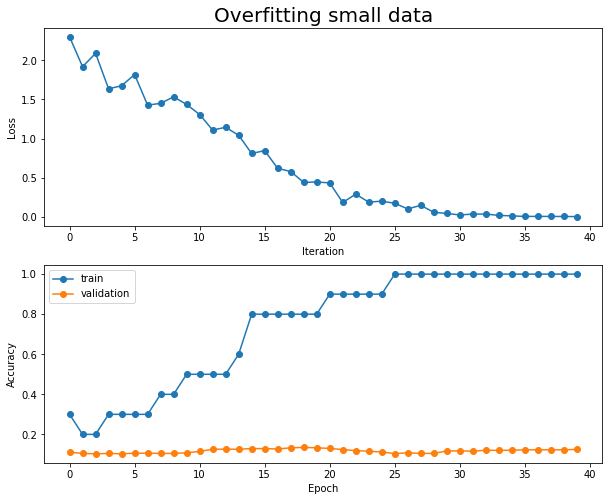

In [ ]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # Setting default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


# Opening file with history for reading in binary mode
with open('../input/cifar10-preprocessed/model_histories_ConvNet1_Overfitting.pickle', 'rb') as f:
    history_dictionary = pickle.load(f, encoding='latin1')  # dictionary type, we use 'latin1' for python3

    
# Plotting history
fig = plt.figure()
plt.subplot(2, 1, 1)
plt.plot(history_dictionary['loss_history'], '-o')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Overfitting small data', fontsize=20)

plt.subplot(2, 1, 2)
plt.plot(history_dictionary['train_accuracy_history'], '-o')
plt.plot(history_dictionary['validation_history'], '-o')
plt.legend(['train', 'validation'], loc='upper left')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()

# Saving plot
fig.savefig('Overfitting_Process.png')
plt.close()


# Training Network

In [ ]:
# # Creating instance of class for 'ConvNet1' and initializing model
# model = ConvNet1(weight_scale=1e-3, hidden_dimension=500, regularization=1e-3)

# # Creating instance of class for training and initializing model
# train = Train(model,
#                 d,
#                 optimization_config={'learning_rate':1e-3},
#                 learning_rate_decay=1.0,
#                 batch_size=50,
#                 number_of_epochs=10,
#                 print_every=20,
#                 verbose_mode=True
#                )

# # Running training process
# train.run()

In [ ]:
# # Saving trained model parameters locally without commiting
# from IPython.display import FileLink

# FileLink('model_params_ConvNet1.pickle')


In [ ]:
# # Saving loss, training accuracy and validation accuracy histories locally without commiting
# from IPython.display import FileLink

# FileLink('model_histories_ConvNet1.pickle')


# Plotting history results for Trained CNN

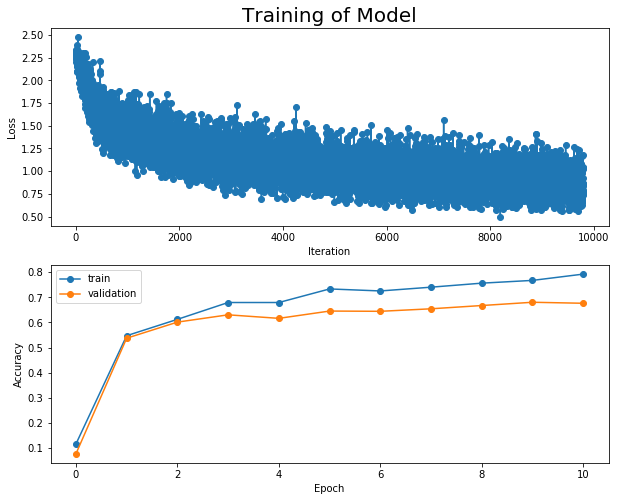

In [ ]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # Setting default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


# Opening file with history for reading in binary mode
with open('../input/cifar10-preprocessed/model_histories_ConvNet1_Training.pickle', 'rb') as f:
    history_dictionary = pickle.load(f, encoding='latin1')  # dictionary type, we use 'latin1' for python3

    
# Plotting history
fig = plt.figure()
plt.subplot(2, 1, 1)
plt.plot(history_dictionary['loss_history'], '-o')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training of Model', fontsize=20)

plt.subplot(2, 1, 2)
plt.plot(history_dictionary['train_accuracy_history'], '-o')
plt.plot(history_dictionary['validation_history'], '-o')
plt.legend(['train', 'validation'], loc='upper left')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()
# Saving plot
fig.savefig('Training_Process.png')
plt.close()


# Visualizing Filters of Convolutional Layer
## After CNN was trained, it is possible to visualize filters and compare them with initialized ones

w1: (32, 3, 7, 7)
b1: (32,)
w2: (8192, 500)
b2: (500,)
w3: (500, 10)
b3: (10,)

w1: (32, 3, 7, 7)
b1: (32,)
w2: (8192, 500)
b2: (500,)
w3: (500, 10)
b3: (10,)


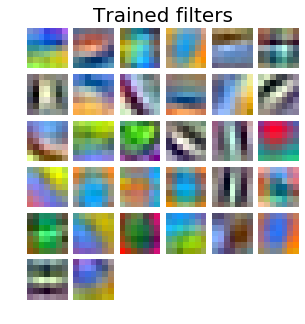

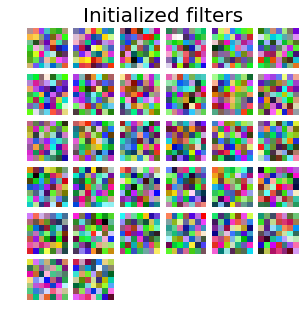

In [ ]:
# Opening file for reading in binary mode
with open('../input/cifar10-preprocessed/model_params_ConvNet1.pickle', 'rb') as f:
    d_trained = pickle.load(f, encoding='latin1')  # dictionary type, we use 'latin1' for python3

# Showing loaded data from file
for i, j in d_trained.items():
    print(i + ':', j.shape)


# Creating instance of class and initializing model
model_1 = ConvNet1()

# Assigning to the new model loaded parameters from 'pickle' file
model_1.params = d_trained

# Showing assigned parameters
print()
for i, j in model_1.params.items():
    print(i + ':', j.shape)


# Preparing function for ploting set of filters
# As input it will take 4D tensor and convert it to the grid
# Values will be scaled to the range [0, 255]
def convert_to_grid(x_input):
    N, H, W, C = x_input.shape
    grid_size = int(ceil(sqrt(N)))
    grid_height = H * grid_size + 1 * (grid_size - 1)
    grid_width = W * grid_size + 1 * (grid_size - 1)
    grid = np.zeros((grid_height, grid_width, C)) + 255
    next_idx = 0
    y0, y1 = 0, H
    for y in range(grid_size):
        x0, x1 = 0, W
        for x in range(grid_size):
            if next_idx < N:
                img = x_input[next_idx]
                low, high = np.min(img), np.max(img)
                grid[y0:y1, x0:x1] = 255.0 * (img - low) / (high - low)
                next_idx += 1
            x0 += W + 1
            x1 += W + 1
        y0 += H + 1
        y1 += H + 1

    return grid


# Visualizing trained filters
# Transposing filters to make channels come at the end
d_trained['w1'] = d_trained['w1'].transpose(0, 2, 3, 1)
# print(d_trained['w1'].shape)  # (32, 7, 7, 3)

# Plotting
fig = plt.figure()
grid = convert_to_grid(d_trained['w1'])
plt.imshow(grid.astype('uint8'))
plt.axis('off')
plt.gcf().set_size_inches(5, 5)
plt.title('Trained filters', fontsize=20)
plt.show()
# Saving plot
fig.savefig('Trained_filters.png')
plt.close()


# Visualizing initialized filters
# Creating instance of class and initializing model
model = ConvNet1()

# Transposing filters to make channels come at the end
model.params['w1'] = model.params['w1'].transpose(0, 2, 3, 1)
# print(model.params['w1'].shape)   # (32, 7, 7, 3)

# Plotting
fig = plt.figure()
grid = convert_to_grid(model.params['w1'])
plt.imshow(grid.astype('uint8'))
plt.axis('off')
plt.gcf().set_size_inches(5, 5)
plt.title('Initialized filters', fontsize=20)
plt.show()
# Saving plot
fig.savefig('Initialized_filters.png')
plt.close()


# Predicting with image from test dataset

w1: (32, 3, 7, 7)
b1: (32,)
w2: (8192, 500)
b2: (500,)
w3: (500, 10)
b3: (10,)

w1: (32, 3, 7, 7)
b1: (32,)
w2: (8192, 500)
b2: (500,)
w3: (500, 10)
b3: (10,)

True label: cat
Predicted label: cat

All scores [[-2.58105205 -7.43219069 -4.07431505  3.49489229 -1.82186642  2.31575485
  -1.5933512  -5.01413514 -6.11077342 -5.44850733]]


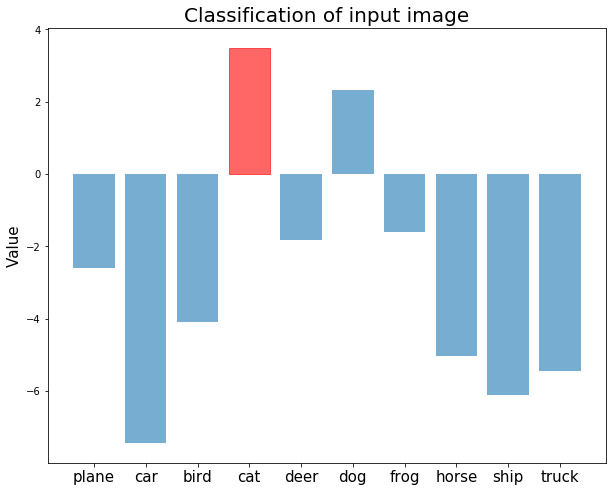

In [ ]:
# Opening file for reading in binary mode
with open('../input/cifar10-preprocessed/model_params_ConvNet1.pickle', 'rb') as f:
    d_trained = pickle.load(f, encoding='latin1')  # dictionary type, we use 'latin1' for python3

# Showing loaded data from file
for i, j in d_trained.items():
    print(i + ':', j.shape)


# Creating instance of class and initializing model
model_1 = ConvNet1()

# Assigning to the new model loaded parameters from 'pickle' file
model_1.params = d_trained

# Showing assigned parameters
print()
for i, j in model_1.params.items():
    print(i + ':', j.shape)


# CIFAR-10 has 10 classes from 0 to 9
labels = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


# Preparing data for predicting from test dataset
x_input = d['x_test'][:1]
y_input = d['y_test'][:1]
# True label
print()
print('True label:', labels[y_input[0]])

# Getting scores from forward pass of input image
scores = model_1.scores_for_predicting(x_input)

# Scores is given for each image with 10 numbers of predictions for each class
# Getting only one class for each image with maximum value
print('Predicted label:', labels[np.argmax(scores, axis=1)[0]])
# Now we have each image with its only one predicted class (index of each row)
# but not with 10 numbers for each class

# Printing all scores
print()
print('All scores', scores)


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # Setting default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Plotting scores
fig = plt.figure()
x_positions = np.arange(len(labels))
barlist = plt.bar(x_positions, scores[0], align='center', alpha=0.6)
barlist[np.argmax(scores)].set_color('red')
plt.xticks(x_positions, labels, fontsize=15)
plt.ylabel('Value', fontsize=15)
plt.title('Classification of input image', fontsize=20)

plt.show()
# Saving plot
fig.savefig('Classification_of_input_image.png')
plt.close()


# Predicting with user's image
## Uploading user's image, than preprocessing it and feeding to the network

(1080, 1920, 3)
(1, 3, 32, 32)
(32, 32, 3)
(32, 32, 3)
(3, 32, 32)
(3, 32, 32)

w1: (32, 3, 7, 7)
b1: (32,)
w2: (8192, 500)
b2: (500,)
w3: (500, 10)
b3: (10,)

Predicted label is horse
Time spent for pedicting: 0.29066 seconds

[[ -8.54511442  -4.40902623  -2.1485959   -0.43065838   0.91998683
    1.28839558   0.18126676   3.13357939 -10.11044309  -1.45438995]]


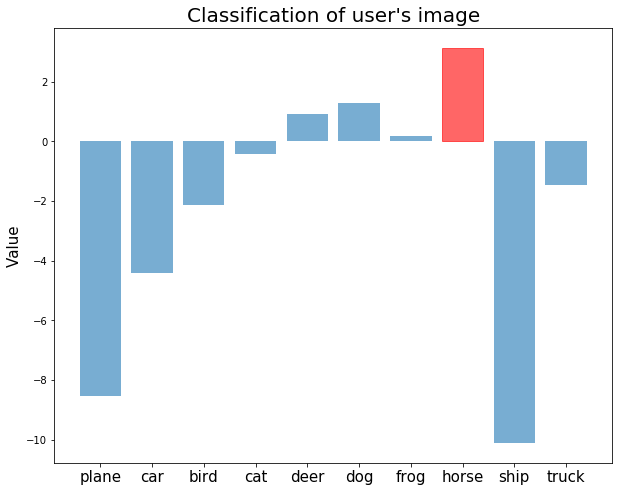

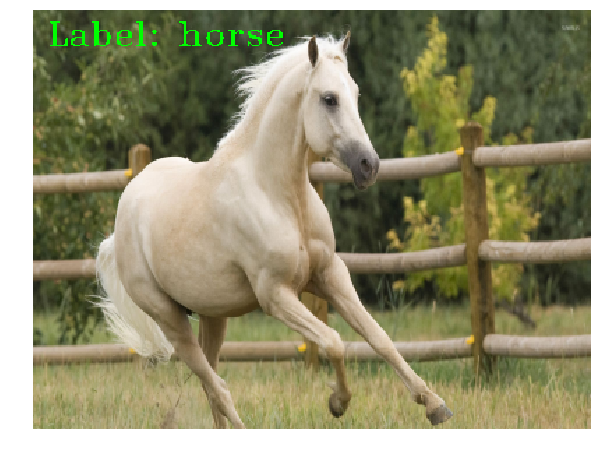

In [ ]:
# Loading input image from file
# Our image initially is in RGB format
# But now we open it in BGR format as function 'cv2.imread' opens it so
x_input = cv2.imread('../input/images-for-testing/horse.jpg')

# Getting image shape
print(x_input.shape)  # (1050, 1680, 3)

# Getting blob from input image
# The 'cv2.dnn.blobFromImage' function returns 4-dimensional blob
# from input image after normalizing, and RB channels swapping
# Resulted shape has number of images, number of channels, width and height
# E.G.: blob = cv2.dnn.blobFromImage(image, scalefactor=1.0, size, swapRB=True)
blob = cv2.dnn.blobFromImage(x_input, 1 / 255.0, (32, 32), swapRB=True, crop=False)

# Getting blob's shape
print(blob.shape)  # (1, 3, 32, 32)


# Preprocessing image in the same way as it was done for training data
# Normalizing by 255.0 we already did in blob, now we need subtract mean image and divide by std image

# Opening file for reading in binary mode
with open('../input/cifar10-preprocessed/mean_and_std.pickle', 'rb') as f:
    mean_and_std = pickle.load(f, encoding='latin1')  # dictionary type, we use 'latin1' for python3

# Getting mean image and std from dictionary
mean_image = mean_and_std['mean_image']
std = mean_and_std['std']

# Getting shape
print(mean_image.shape)  # (32, 32, 3)
print(std.shape)  # (32, 32, 3)

# Transposing mean and std to make channels come first as we have it now in blob image
mean_image = mean_image.transpose(2, 0, 1)
std = std.transpose(2, 0, 1)

# Getting shape
print(mean_image.shape)  # (3, 32, 32)
print(std.shape)  # (3, 32, 32)
print()

# Subtracting mean image from blob
blob[0] -= mean_image
# Dividing by standard deviation
blob[0] /= std


# CIFAR-10 has 10 classes from 0 to 9
labels = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Opening file for reading in binary mode
with open('../input/cifar10-preprocessed/model_params_ConvNet1.pickle', 'rb') as f:
    d_trained = pickle.load(f, encoding='latin1')  # dictionary type, we use 'latin1' for python3

# Creating instance of class and initializing model
model = ConvNet1()

# Assigning to the new model loaded parameters from 'pickle' file
model.params = d_trained

# Showing assigned parameters
for i, j in model.params.items():
    print(i + ':', j.shape)
print()
    
# Getting scores from forward pass of input image
# Measuring at the same time execution time
start = timer()
scores = model.scores_for_predicting(blob)
end = timer()

# Scores is given for each image with 10 numbers of predictions for each class
# Getting only one class for each image with maximum value
print('Predicted label is', labels[np.argmax(scores, axis=1)[0]])
print('Time spent for pedicting: {} seconds'.format(round(end - start, 5)))
print()
# Now we have each image with its only one predicted class (index of each row)
# but not with 10 numbers for each class

# Printing all scores
print(scores)

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # Setting default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Plotting scores
fig = plt.figure()
x_positions = np.arange(len(labels))
barlist = plt.bar(x_positions, scores[0], align='center', alpha=0.6)
barlist[np.argmax(scores)].set_color('red')
plt.xticks(x_positions, labels, fontsize=15)
plt.ylabel('Value', fontsize=15)
plt.title('Classification of user\'s image', fontsize=20)

plt.show()
# Saving plot
fig.savefig('Classification_of_users_image.png')
plt.close()


# Showing image with predicted label
# Resizing image
x_input = cv2.resize(x_input, (400, 300), interpolation=cv2.INTER_AREA)

# Preparing text with label and score
text = 'Label: {}'.format(labels[np.argmax(scores, axis=1)[0]])

# Preparing colour
colour = [0, 255, 0]

# Putting text with label and confidence on the original image
cv2.putText(x_input, text, (10, 25), cv2.FONT_HERSHEY_TRIPLEX, 0.8, colour, 1)

# Showing resulted image
fig = plt.figure()
plt.imshow(cv2.cvtColor(x_input, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()
# Saving plot
fig.savefig('Users_image_with_label.png')
plt.close()
